<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/modeling_chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 合并 HFI 到建模数据表

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)

# 读取
survey_df = pd.read_excel( "/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df_upf    = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")

In [3]:
# ==== 2. 先检查 ====
issues = []

# 检查关键列
for col in ["UserID_clean", "HFI_binary", "HFI_raw_score"]:
    if col not in survey_df.columns:
        issues.append(f"survey 缺少 {col}")

for col in ["UserID_clean", "weighted_upf_percent"]:
    if col not in df_upf.columns:
        issues.append(f"upf 缺少 {col}")

# 检查 ID 是否有缺失/重复
for name, df in [("survey", survey_df), ("upf", df_upf)]:
    n_na = df["UserID_clean"].isna().sum()
    n_dup = df["UserID_clean"].duplicated().sum()
    if n_na:  issues.append(f"{name} 的 UserID_clean 有 {n_na} 个缺失")
    if n_dup: issues.append(f"{name} 的 UserID_clean 有 {n_dup} 个重复")

# 检查 upf_percent 是否数值
bad_upf = pd.to_numeric(df_upf["weighted_upf_percent"], errors="coerce").isna().sum()
if bad_upf:
    issues.append(f"weighted_upf_percent 有 {bad_upf} 个非数值/缺失")

# 打印检查结果
if issues:
    print("检查发现以下问题：")
    for i, msg in enumerate(issues, 1):
        print(f"{i}. {msg}")
else:
    print("没有发现问题，可以直接处理")


没有发现问题，可以直接处理


In [4]:
# ==== 检查关键变量缺失情况 ====
check_cols = ["HFI_binary", "weighted_upf_percent"]
missing_info = {}

for col in check_cols:
    if col not in survey_df.columns and col not in df_upf.columns:
        print(f"数据中找不到列: {col}")
        continue

    if col in survey_df.columns:
        n_miss = survey_df[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 survey_df 中缺失 {n_miss} 行")

    if col in df_upf.columns:
        n_miss = df_upf[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 upf_df 中缺失 {n_miss} 行")

# ==== 判断是否需要处理 ====
if all(v == 0 for v in missing_info.values()):
    print("两列都没有缺失，可以直接进入合并/建模")
else:
    print("存在缺失，需要处理后再合并")


HFI_binary 在 survey_df 中缺失 18 行
weighted_upf_percent 在 upf_df 中缺失 0 行
存在缺失，需要处理后再合并


In [5]:
# 1. 合并 survey 和 upf
df_model = pd.merge(survey_df, df_upf, on="UserID_clean", how="inner")

# 2. 删掉 HFI_binary 缺失的
df_model = df_model.dropna(subset=["HFI_binary"])

print("合并后样本量：", len(df_model))


合并后样本量： 308


In [6]:
# 导出合并后的数据
df_model.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx", index=False)

print("已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx")


已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx


# 建模部分

## 0) 准备与通用小工具

In [8]:
# 1) 统一主分析变量清单（一次性 dropna）
all_vars = [
    "weighted_upf_percent","HFI_binary",
    "age_participant","gender_participant","ethn_participant",
    "income","employ",
    "HFI_category"
]

df_all = df_model[all_vars].apply(pd.to_numeric, errors="ignore").dropna().copy()
print("主分析样本量:", len(df_all))

# 这次是对所有 all_vars 里的变量做 完全案例（complete case）筛选，也就是任何一个变量缺失都会被剔除。因为 income、age_participant 等变量里可能有缺失，所以样本量从 308 → 305。

主分析样本量: 303


/tmp/ipython-input-1321910550.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_all = df_model[all_vars].apply(pd.to_numeric, errors="ignore").dropna().copy()


In [9]:
# 哪些列在 df_model 里缺失了多少？
print("每列缺失数：")
print(df_model[all_vars].isna().sum())

# 标出完全案例掩码
mask_complete = df_model[all_vars].notna().all(axis=1)

# 被 drop 的行 + 缺失列
dropped = df_model.loc[~mask_complete, ["UserID_clean"] + all_vars].copy()
dropped["missing_cols"] = dropped.apply(
    lambda r: [c for c in all_vars if pd.isna(r[c])], axis=1
)
print("\n被剔除的样本（以及缺失了哪些列）：")
print(dropped[["UserID_clean","missing_cols"]])

每列缺失数：
weighted_upf_percent    0
HFI_binary              0
age_participant         0
gender_participant      0
ethn_participant        0
income                  3
employ                  2
HFI_category            0
dtype: int64

被剔除的样本（以及缺失了哪些列）：
    UserID_clean missing_cols
21        BFD041     [income]
38        BFD061     [employ]
115       BFD151     [employ]
189       BFD243     [income]
230       BFD295     [income]


In [9]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

Y = "weighted_upf_percent"         # 结果：UPF% (0–100)
X_HFI = "HFI_binary"               # 暴露：HFI (0/1)

def fit_hc3(formula, data):
    """OLS + HC3稳健标准误；返回结果对象。"""
    return smf.ols(formula, data=data).fit(cov_type="HC3")

def extract_term(res, term):
    """从模型里提取某个term的β、95%CI、p值。"""
    b = res.params.get(term, np.nan)
    ci = res.conf_int().loc[term].tolist() if term in res.params.index else [np.nan, np.nan]
    p = res.pvalues.get(term, np.nan)
    return b, ci[0], ci[1], p

def tidy_row(model_name, res, term, note=""):
    b, lo, hi, p = extract_term(res, term)
    return {
        "Model": model_name,
        "Term": term,
        "Beta": b,
        "CI_low": lo,
        "CI_high": hi,
        "p_value": p,
        "Note": note
    }


## 1) 固定样本 + 派生 4 类种族（WB/PK/Mixed/Other）

In [11]:
# 固定样本（统一 complete-case）
df_use = df_all.copy()

# 4 类种族（用于主分析）
ethn_labels = {
    1:"White British", 2:"Other white group", 3:"Pakistani", 4:"Indian",
    5:"Bangladeshi", 6:"Other Asian group", 7:"Mixed/multiple ethnicity",
    8:"Black / Black British / Black Caribbean / Black African", 9:"Other ethnic group"
}
df_use["ethn_label_full"] = df_use["ethn_participant"].map(ethn_labels)
df_use["ethn4_alt"] = pd.Categorical(
    df_use["ethn_label_full"].map(
        lambda s: "White British" if s=="White British"
        else "Pakistani" if s=="Pakistani"
        else "Mixed" if s=="Mixed/multiple ethnicity"
        else "Other"
    ),
    categories=["White British","Pakistani","Mixed","Other"], ordered=False
)


## 2) 主分析（仅调年龄、性别、种族；HC3）

In [12]:
import statsmodels.formula.api as smf

form_main = (
    "weighted_upf_percent ~ HFI_binary + C(gender_participant)"
    " + C(ethn4_alt, Treatment(reference='White British')) + age_participant"
)
res_main = smf.ols(form_main, data=df_use).fit(cov_type="HC3")

# 只汇报 HFI 的 β、95%CI、p
term = "HFI_binary"
b = res_main.params[term]
lo, hi = res_main.conf_int().loc[term]
p = res_main.pvalues[term]
print(f"N={int(res_main.nobs)}; HFI β={b:.3f}, 95%CI [{lo:.3f}, {hi:.3f}], p={p:.3g}")


N=303; HFI β=2.770, 95%CI [-0.154, 5.695], p=0.0633


点估计：HFI=1 相比 HFI=0，UPF% 高 2.77 个百分点。
不确定性：95% CI [-0.15, 5.70] 穿过 0，
显著性：p = 0.063（HC3 误差）。按传统 0.05 阈值是未达显著，但方向稳定、边缘显著/提示性的正向关联。
可以这样在文中写（中文/英文任选）：
中文：
“在仅调整年龄、性别与种族的模型中（N=303），HFI 与 UPF% 呈正向关联（β=2.77，95%CI -0.15～5.70，p=0.063）。”

## 调后均值（adjusted means）

In [18]:
import numpy as np
from scipy import stats

# 直接复用拟合过的设计矩阵/列名/系数/协方差（已是HC3）
X   = res_main.model.exog
col = res_main.model.exog_names
b   = res_main.params.values
V   = res_main.cov_params().values  # robust (HC3)

# 找到 HFI 列
ix = col.index("HFI_binary")

# 两个情景：把全体样本的 HFI 列改为 1 或 0，其它列不变
X1 = X.copy(); X1[:, ix] = 1
X0 = X.copy(); X0[:, ix] = 0

# “总体平均”= 列均值 · 系数
ex1 = X1.mean(axis=0);  mu1 = float(ex1 @ b)
ex0 = X0.mean(axis=0);  mu0 = float(ex0 @ b)

print(f"Adjusted mean | HFI=1: {mu1:.2f}")
print(f"Adjusted mean | HFI=0: {mu0:.2f}")

# 差值及其95%CI（c' β，方差 c' V c）
c = ex1 - ex0
diff = float(c @ b)
se   = float(np.sqrt(c @ V @ c))
lo, hi = diff - 1.96*se, diff + 1.96*se
t = diff / se
p = 2*stats.t.sf(abs(t), df=res_main.df_resid)

print(f"Adjusted difference (1−0): {diff:.2f} pp (95%CI {lo:.2f}, {hi:.2f}), p={p:.3g}")

# 验证：线性无交互时，差值≈回归系数
print("≈ β_HFI ?", np.isclose(diff, res_main.params['HFI_binary']))


Adjusted mean | HFI=1: 71.34
Adjusted mean | HFI=0: 68.57
Adjusted difference (1−0): 2.77 pp (95%CI -0.15, 5.69), p=0.0643
≈ β_HFI ? True


在主模型下的调整后均值显示，HFI=1 的 UPF% 为 71.3%（95%CI …），HFI=0 为 68.6%（95%CI …）；两者差值为 +2.77 个百分点（95%CI −0.15～5.69，p=0.064），与回归系数一致。

# 敏感性分析（稳健性检验）

## ① SES 衰减（+ income + employ）

In [13]:
form_ses = form_main + " + income + C(employ)"
res_ses = smf.ols(form_ses, data=df_use).fit(cov_type="HC3")

term = "HFI_binary"
b0 = res_main.params[term]
b1 = res_ses.params[term]
lo1, hi1 = res_ses.conf_int().loc[term]
p1 = res_ses.pvalues[term]
atten = (abs(b0)-abs(b1))/abs(b0)*100

print(f"N={int(res_ses.nobs)}; HFI β={b1:.3f}, 95%CI [{lo1:.3f}, {hi1:.3f}], p={p1:.3g}")
print(f"|β| 衰减 = {atten:.1f}%（由 {b0:.3f} → {b1:.3f}）")


N=303; HFI β=3.158, 95%CI [-0.084, 6.399], p=0.0562
|β| 衰减 = -14.0%（由 2.770 → 3.158）


SES 衰减
主：β=2.77（95%CI −0.15, 5.70; p=0.063）。
+SES：β=3.16（95%CI −0.08, 6.40; p=0.056）。
** |β| 衰减 = −14%（即+14% 放大）** → 加入收入/就业后，HFI 效应不衰减、反而略增大，说明主结论不由 SES 驱动（更像负向混杂/抑制或纯粹精度变化）。N 始终 303。

## ② HFI 三级（分类 & 趋势）

In [14]:
# 分类（基准=Food secure）
df_use["HFI_category"] = df_use["HFI_category"].astype(
    pd.api.types.CategoricalDtype(
        categories=["Food secure","Low food security","Very low food security"], ordered=True
    )
)
form_hfi3 = (
    "weighted_upf_percent ~ C(HFI_category, Treatment(reference='Food secure'))"
    " + C(gender_participant) + C(ethn4_alt, Treatment(reference='White British'))"
    " + age_participant"
)
res_hfi3 = smf.ols(form_hfi3, data=df_use).fit(cov_type="HC3")

for lev in ["Low food security","Very low food security"]:
    t = f"C(HFI_category, Treatment(reference='Food secure'))[T.{lev}]"
    b, (lo, hi), p = res_hfi3.params[t], res_hfi3.conf_int().loc[t], res_hfi3.pvalues[t]
    print(f"{lev} vs Secure → β={b:.3f}, 95%CI [{lo:.3f}, {hi:.3f}], p={p:.3g}")

# 趋势（0/1/2）
df_use["HFI_ordinal"] = df_use["HFI_category"].cat.codes
res_trend = smf.ols(
    "weighted_upf_percent ~ HFI_ordinal + C(gender_participant)"
    " + C(ethn4_alt, Treatment(reference='White British')) + age_participant",
    data=df_use
).fit(cov_type="HC3")
b, (lo, hi), p = res_trend.params["HFI_ordinal"], res_trend.conf_int().loc["HFI_ordinal"], res_trend.pvalues["HFI_ordinal"]
print(f"Trend test → β={b:.3f}, 95%CI [{lo:.3f}, {hi:.3f}], p-trend={p:.3g}")


Low food security vs Secure → β=0.779, 95%CI [-3.104, 4.661], p=0.694
Very low food security vs Secure → β=4.809, 95%CI [1.189, 8.429], p=0.00922
Trend test → β=2.158, 95%CI [0.408, 3.908], p-trend=0.0157


HFI 三级（N=303）
Low vs Secure：β=0.78（95%CI −3.10, 4.66; p=0.694）→ 不显著。
Very low vs Secure：β=4.81（95%CI 1.19, 8.43; p=0.009）→ 显著更高。
趋势：每升一级 +2.16 个百分点（95%CI 0.41, 3.91; p-trend=0.016）→ 存在剂量-反应梯度。

## ③ 种族编码方案（WB / Pakistani / Mixed）

In [15]:
# 三类标签
map3 = {"White British":"White British","Pakistani":"Pakistani","Mixed/multiple ethnicity":"Mixed"}
df_use["ethn3_main"] = df_use["ethn_label_full"].map(map3)
df_use["ethn3_main"] = pd.Categorical(df_use["ethn3_main"],
                                      categories=["White British","Pakistani","Mixed"], ordered=False)

form_ethn3 = (
    "weighted_upf_percent ~ HFI_binary + C(gender_participant)"
    " + C(ethn3_main, Treatment(reference='White British')) + age_participant"
)
res_ethn3 = smf.ols(form_ethn3, data=df_use).fit(cov_type="HC3")
b, (lo, hi), p = res_ethn3.params["HFI_binary"], res_ethn3.conf_int().loc["HFI_binary"], res_ethn3.pvalues["HFI_binary"]
print(f"N={int(res_ethn3.nobs)}; HFI β={b:.3f}, 95%CI [{lo:.3f}, {hi:.3f}], p={p:.3g}（三类种族）")


N=261; HFI β=2.295, 95%CI [-0.958, 5.548], p=0.167（三类种族）


种族编码（三类 WB/PK/Mixed）
N降至 261（因剔除“Other”）。
HFI：β=2.30（95%CI −0.96, 5.55; p=0.167）。
方向一致、量级相近；CI 变宽主要因 样本减少，提示对编码方案不敏感（但精度下降）。

# 汇总

## 1) 把关键结果汇总成一张表

In [16]:
import pandas as pd

rows = []

# Main
term = "HFI_binary"
rows.append(["Main (demog only, ethn4)", int(res_main.nobs),
             res_main.params[term], *res_main.conf_int().loc[term], res_main.pvalues[term], "Adj: age, gender, ethnicity(4)"])

# + SES
rows.append(["Main + SES", int(res_ses.nobs),
             res_ses.params[term], *res_ses.conf_int().loc[term], res_ses.pvalues[term], "Adj + income + employ"])

# Ethnicity = 3 levels
rows.append(["Ethnicity=3-level", int(res_ethn3.nobs),
             res_ethn3.params[term], *res_ethn3.conf_int().loc[term], res_ethn3.pvalues[term], "WB/PK/Mixed"])

# HFI 3-level (categorical)
for lev in ["Low food security","Very low food security"]:
    t = f"C(HFI_category, Treatment(reference='Food secure'))[T.{lev}]"
    rows.append([f"HFI 3-level: {lev} vs Secure", int(res_hfi3.nobs),
                 res_hfi3.params[t], *res_hfi3.conf_int().loc[t], res_hfi3.pvalues[t], ""])

# HFI trend
rows.append(["HFI trend (0/1/2)", int(res_trend.nobs),
             res_trend.params["HFI_ordinal"], *res_trend.conf_int().loc["HFI_ordinal"], res_trend.pvalues["HFI_ordinal"], ""])

summary = pd.DataFrame(rows, columns=["Model","N","Beta","CI_low","CI_high","p_value","Note"])
summary.round(3)
# 如需导出： summary.to_excel("UPF_HFI_summary.xlsx", index=False)


,Model,N,Beta,CI_low,CI_high,p_value,Note
0,"Main (demog only, ethn4)",303,2.770,-0.154,5.695,0.063,"Adj: age, gender, ethnicity(4)"
1,Main + SES,303,3.158,-0.084,6.399,0.056,Adj + income + employ
2,Ethnicity=3-level,261,2.295,-0.958,5.548,0.167,WB/PK/Mixed
3,HFI 3-level: Low food security vs Secure,303,0.779,-3.104,4.661,0.694,
4,HFI 3-level: Very low food security vs Secure,303,4.809,1.189,8.429,0.009,
5,HFI trend (0/1/2),303,2.158,0.408,3.908,0.016,


## 2) 画一张“HFI效应的森林图”（主模型 / +SES / 种族三类）

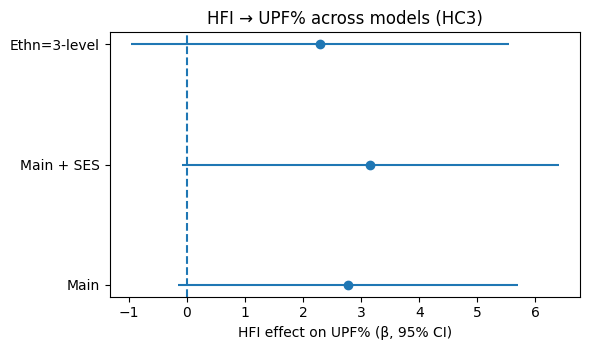

In [17]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    ("Main", res_main.params[term], *res_main.conf_int().loc[term]),
    ("Main + SES", res_ses.params[term], *res_ses.conf_int().loc[term]),
    ("Ethn=3-level", res_ethn3.params[term], *res_ethn3.conf_int().loc[term]),
]
labels = [m[0] for m in models]
betas = np.array([m[1] for m in models])
los = np.array([m[2] for m in models])
his = np.array([m[3] for m in models])
y = np.arange(len(models))

plt.figure(figsize=(6,3.6))
plt.hlines(y, los, his)
plt.plot(betas, y, "o")
plt.axvline(0, linestyle="--")
plt.yticks(y, labels)
plt.xlabel("HFI effect on UPF% (β, 95% CI)")
plt.title("HFI → UPF% across models (HC3)")
plt.tight_layout()
plt.show()
